# What TOC rules have had the biggest impact?

We would like to evaluate which Transit Oriented Communities rules have had the biggest impact,
and which transit lines have seen the most development.

We will proceed by reconstructing a TOC map,so we can assign developments to specific transit lines.

In [1]:
import boto3
import contextily
import datetime
import functools
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import toc

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")
city_boundary = catalog.city_boundary.read()

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

We will err on the side of finding ineligible lines, since headways and stops can change.
In order to do that, we will have a headway cutoff greater than the TOC cutoff of 15 minutes,
and buffer the tiers an additional 20%.

In [3]:
cutoff = 18.0
cushion = 1.2

## TOC Tiers from bus service

Let's read some GTFS feeds to get representative weekday peak frequencies for
Metro Bus, Santa Monica Big Blue Bus, and Culver City Bus:

In [4]:
# Current Metro GTFS
# METRO_BUS_GTFS_URL = "https://gitlab.com/LACMTA/gtfs_bus/-/raw/master/gtfs_bus.zip?inline=false"

# Metro GTFS from December 2017
#METRO_BUS_GTFS_URL = "https://gitlab.com/LACMTA/gtfs_bus/-/raw/aef844c79c31c40ef751a3472b3882406307b05a/gtfs_bus.zip?inline=false"
METRO_BUS_GTFS_URL = f"s3://{bucket_name}/data/source/LA_Metro_GTFS/gtfs_bus.zip"

# Current Big Blue Bus GTFS
#BBB_GTFS_URL = "http://gtfs.bigbluebus.com/current.zip"
BBB_GTFS_URL = f"s3://{bucket_name}/data/source/Big_Blue_Bus_GTFS/current.zip"

# Current 
#CC_GTFS_URL = "https://www.culvercity.org/home/showdocument?id=18585"
CC_GTFS_URL = f"s3://{bucket_name}/data/source/Culver_City_GTFS/culvercitybus-Jan2020.zip"

# A cutoff headway, in minutes, for determining TOC eligible bus lines.
# This is highter than the TOC value of 15 minutes, but we want to err
# on the side of catching edge cases, or cases where the frequency has
# changed since the TOC entitlement.

test_date = datetime.date(2018, 2, 8)

# Load TOC lines for Metro, Big Blue Bus, and Culver City Bus
metro_bus_toc_lines = toc.toc_bus_lines(
    METRO_BUS_GTFS_URL,
    cutoff=cutoff,
    test_date=test_date,
)
bbb_toc_lines = toc.toc_bus_lines(BBB_GTFS_URL, cutoff=cutoff)
cc_toc_lines = toc.toc_bus_lines(CC_GTFS_URL, cutoff=cutoff)

# Combine into one.
toc_bus_lines = pd.concat(
    [metro_bus_toc_lines, bbb_toc_lines, cc_toc_lines],
    axis=0,
    sort=False
)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

We now find where the TOC eligible bus lines intersect,
and compute tier geometries for those intersections.

In [5]:
toc_bus_intersections = toc.bus_intersections(toc_bus_lines)
toc_bus_intersection_tiers = toc.compute_toc_tiers_from_bus_intersections(
    toc_bus_intersections,
    city_boundary,
    cushion=cushion,
)

Let's create a plot of the TOC tiers due to bus intersections:

In [6]:
colors = ["#f1eef6", "#bdc9e1", "#74a9cf", "#0570b0"]
def plot_toc_tiers(gdf):
    fig, ax = plt.subplots(figsize=(16,16))
    WEB_MERCATOR = 3857
    city_boundary.to_crs(f"EPSG:{WEB_MERCATOR}").plot(ax=ax, alpha=0.1, color="gray")
    for color, tier in zip(colors, range(1,5)):
        colname = f"tier_{tier}"
        t = gdf.set_geometry(colname)
        if not t[colname].is_empty.all():
            t.to_crs(f"EPSG:{WEB_MERCATOR}").plot(ax=ax, color=color)
    contextily.add_basemap(ax, source=contextily.providers.Stamen.TonerLite)
    return fig

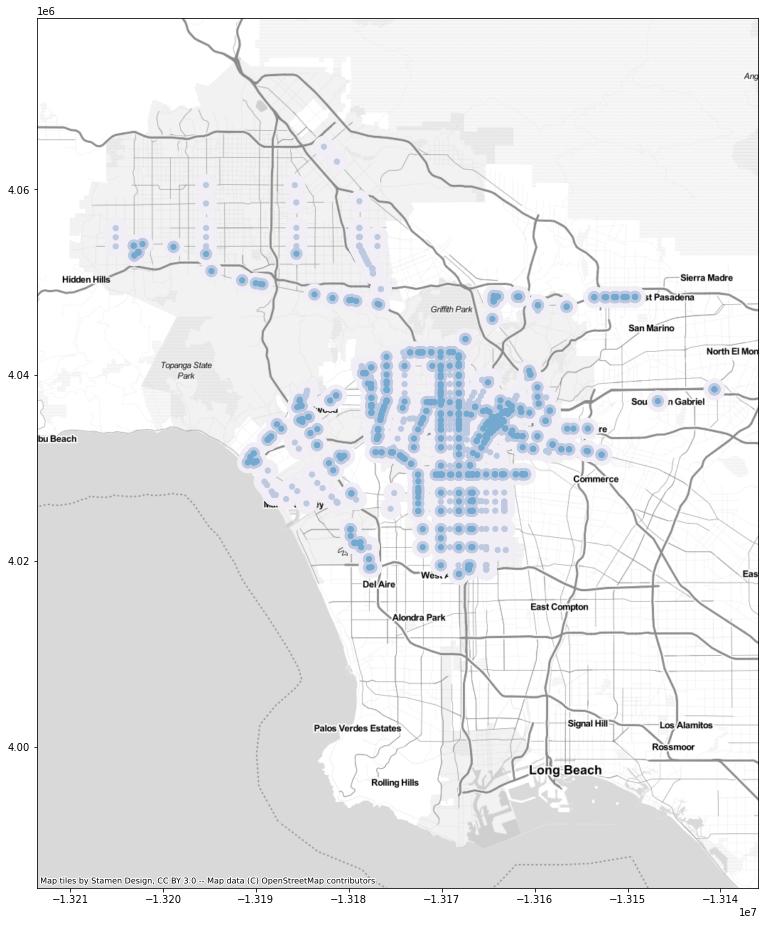

In [7]:
fig = plot_toc_tiers(toc_bus_intersection_tiers)
fig.show()

# TOC Tiers from Metrolink service

Metrolink stations (few though they may be) also generate TOC zones.
Here we create TOC tiers from the those:

In [8]:
metrolink_stations = catalog.metrolink_stations.read()
toc_metrolink_tiers = toc.compute_toc_tiers_from_metrolink_stations(
    metrolink_stations,
    city_boundary,
    cushion=cushion,
)

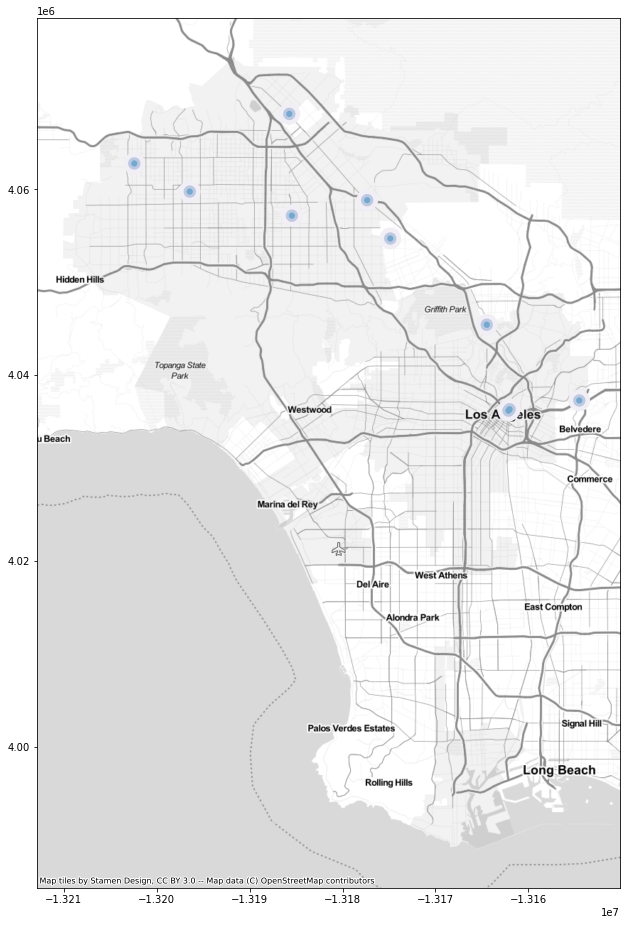

In [9]:
fig = plot_toc_tiers(toc_metrolink_tiers)
fig.show()

## TOC Tiers from Metro rail service

The most impactful TOC zones are from Metro rail stations.
Planned stations are included in TOC considerations, so we also
bring in data for the Crenshaw Line, the Purple Line, and the Regional Connector:

In [10]:
metro_rail_stations = catalog.metro_rail_stations.read()
# Read Crenshaw, Purple Line, and Regional Connector data from LA Times datadesk,
# who produced GeoJSON from Metro planning documents. I was not able to find
# the data elsewhere.
crenshaw = gpd.read_file(
    "https://raw.githubusercontent.com/datadesk/lametro-maps/master/planned-crenshaw-stops.geojson"
).rename(
    columns={"station": "STATION", "line": "LINE"}
).assign(LINENUM2=None, LINENUM=-1)
purple = gpd.read_file(
    "https://raw.githubusercontent.com/datadesk/lametro-maps/master/planned-purple-line-extension-stops.geojson"
).rename(
    columns={"name": "STATION"}
).assign(LINENUM2=None, LINENUM=805, LINE="Purple").drop(
    columns=["marker-color", "marker-size", "marker-symbol"]
)
regional_connector = gpd.read_file(
    "https://github.com/datadesk/lametro-maps/raw/master/planned-regional-connector-stops.json"
).assign(LINENUM2=None, LINENUM=801, LINE="Regional Connector")


all_metro_rail_stations = metro_rail_stations.append(crenshaw, sort = False).append(
                        purple, sort = False).append(regional_connector, sort = False)

all_metro_rail_stations.to_file(driver = 'GeoJSON', 
                                filename = '../gis/intermediate/active_planned_metro_rail_stations.geojson')

s3.upload_file('../gis/intermediate/active_planned_metro_rail_stations.geojson', 
               f'{bucket_name}', 'gis/intermediate/active_planned_metro_rail_stations.geojson')


toc_metro_rail_tiers = toc.compute_toc_tiers_from_metro_rail(
    metro_rail_stations.append(crenshaw, sort=False)
    .append(purple, sort=False)
    .append(regional_connector, sort=False),
    toc_bus_lines,
    city_boundary,
    cushion=cushion,
)

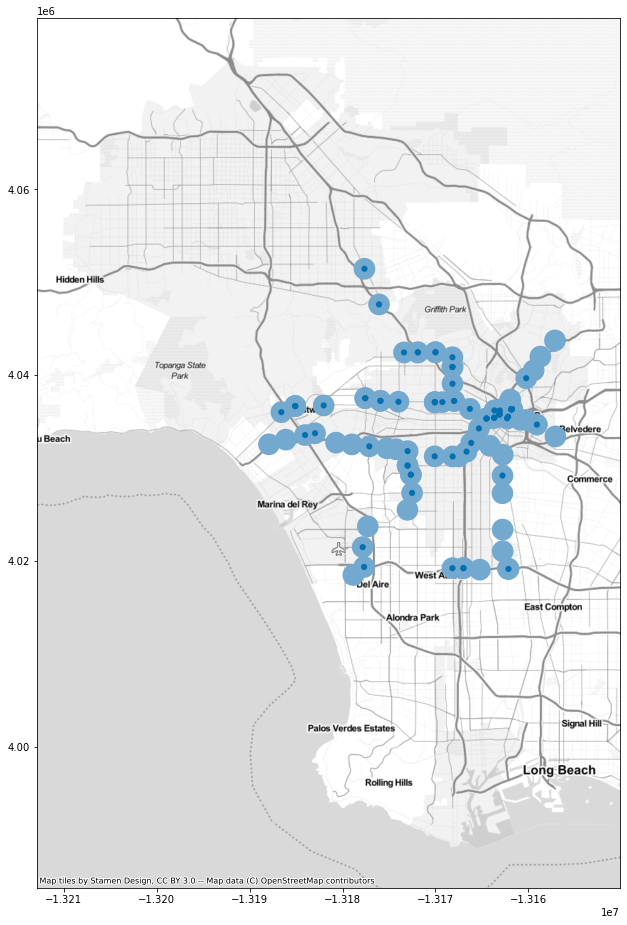

In [11]:
fig = plot_toc_tiers(toc_metro_rail_tiers)
fig.show()

## Full TOC tiers

All of the TOC tiers from above may be combined into a single TOC map:

In [12]:
# Standardize columns before concatenating
toc_bus_intersection_tiers2 = toc.standardize_bus(toc_bus_intersection_tiers)
toc_metrolink_tiers2 = toc.standardize_metrolink(toc_metrolink_tiers)
toc_metro_rail_tiers2 = toc.standardize_metro(toc_metro_rail_tiers)

In [13]:
# Check the CRS is correct before concatenating
for dataframe in [toc_bus_intersection_tiers2, toc_metrolink_tiers2, toc_metro_rail_tiers2]:
    print(dataframe.tier_1.crs)
    print(dataframe.tier_2.crs)
    print(dataframe.tier_3.crs)
    print(dataframe.tier_4.crs)
    print(dataframe.geometry.crs)

EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326


In [14]:
col_order = [
    "line_id_a", "line_id_b", "line_name_a", "line_name_b", "station_id", "station_name",
    "geometry", "tier_1", "tier_2", "tier_3", "tier_4",
    "mode_a", "mode_b", "agency_a", "agency_b", 
]

toc_tiers = pd.concat([
        toc_bus_intersection_tiers2,
        toc_metrolink_tiers2,
        toc_metro_rail_tiers2,
    ],
    axis=0,
    sort=False
).reindex(columns = col_order)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



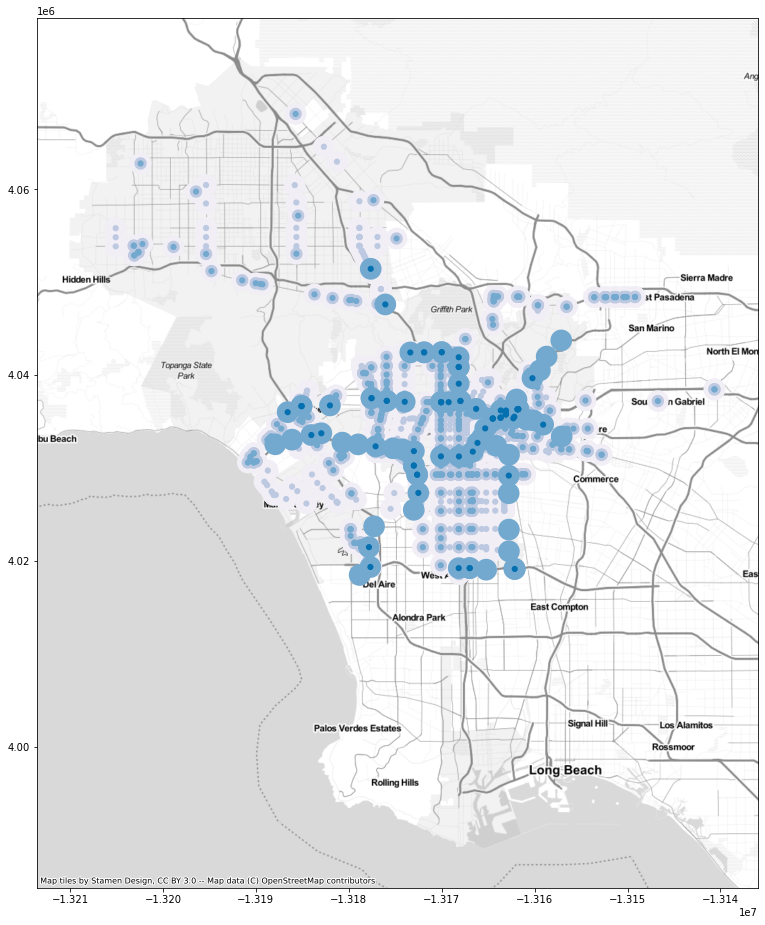

In [15]:
def more_fixes(df):
    # Fill in NaNs with empty string
    transit_info = ['line_id_a', 'line_id_b', 
                    'line_name_a', 'line_name_b', 
                    'station_id', 'station_name', 
                    'mode_a', 'mode_b', 
                    'agency_a', 'agency_b']
    
    df[transit_info] = df[transit_info].fillna('')
    

    for col in ['mode_b', 'agency_b']:
        df[col] = df.apply(lambda row: "" if row.line_id_b == "" else row[col], axis = 1)
    
    # Drop duplicates (there are some stations where tier_4 geometry isn't filled in, but otherwise, same info)
    for col in ['tier_1', 'tier_2', 'tier_3', 'tier_4']:
        new_col = f'{col}_area'
        df[new_col] = df.set_geometry(col).geometry.area

    df = (df.sort_values(
            ['tier_1_area', 'tier_2_area', 'tier_3_area', 'tier_4_area'], 
            ascending = [False, False, False, False])
          .drop_duplicates(subset = transit_info, keep = 'first') 
         )

    drop_col = ['tier_1_area', 'tier_2_area', 'tier_3_area', 'tier_4_area']
    df = (df.drop(columns = drop_col)
          .sort_values(['mode_a', 'mode_b', 'line_id_a', 'line_id_b','station_id'])
          .reset_index(drop=True)
         )
    
    # Add a tiers_id to make it easier to reconstruct later on
    df = df.assign(
        tiers_id = df.index + 1
    )

    return df

toc_tiers = more_fixes(toc_tiers)

fig = plot_toc_tiers(toc_tiers)
fig.show()

In [16]:
ALL_GEOM_COLS = ["geometry", "tier_1", "tier_2", "tier_3", "tier_4"]

def set_geometry_and_save(df, geom_col):
    drop_me = [c for c in ALL_GEOM_COLS if c != geom_col]
    print(drop_me)
    if geom_col=="geometry":
        value = 0
    else:
        value = geom_col.replace("tier_", "")
    
    (df.drop(columns = drop_me)
     .set_geometry(geom_col)
     .to_file(driver = "GeoJSON", 
              filename = f"../gis/intermediate/reconstructed_toc_tiers_{value}.geojson")
    )
    
    # Upload to S3
    s3.upload_file(f"../gis/intermediate/reconstructed_toc_tiers_{value}.geojson", 
                   bucket_name, 
                  f"gis/intermediate/reconstructed_toc_tiers_{value}.geojson")

In [17]:
set_geometry_and_save(toc_tiers, "tier_1")
set_geometry_and_save(toc_tiers, "tier_2")
set_geometry_and_save(toc_tiers, "tier_3")
set_geometry_and_save(toc_tiers, "tier_4")
set_geometry_and_save(toc_tiers, "geometry")

['geometry', 'tier_2', 'tier_3', 'tier_4']
['geometry', 'tier_1', 'tier_3', 'tier_4']
['geometry', 'tier_1', 'tier_2', 'tier_4']
['geometry', 'tier_1', 'tier_2', 'tier_3']
['tier_1', 'tier_2', 'tier_3', 'tier_4']
